# Imports

In [3]:
import copy
import datetime
import glob
import json
import os
import pathlib
from collections import defaultdict
from importlib import reload
from typing import Dict, List, Optional

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm import tqdm

import experiment_utils

experiment_utils = reload(experiment_utils)

# Constants

In [4]:
AGENT = "human"

ALL_DATA_SPLITS = ["combined", "human_alone", "human_with_assistant"]

# All participant IDs used to collect data for the BC models.
PARTICIPANT_IDS = ["3", "4", "7", "9", "11"]

# Lists of BC data. Each element containts the name/tag, directory, and dataset size.
# BC_DATA = [
#     (
#         "human_alone_no_noops",
#         "/nas/ucb/cassidy/minecraft-building-assistance-game/data/human_data_cleaned/human_alone/infinite_blocks_true/rllib_no_noops_flat_actions_flat_observations_player_0",
#         9642,
#         # "/nas/ucb/cassidy/minecraft-building-assistance-game/data/human_data_cleaned/human_alone/infinite_blocks_true/rllib_no_noops_flat_actions_flat_observations_place_wrong_reward_-1_player_0",
#     ),
#     (
#         "human_alone_with_noops",
#         "/nas/ucb/cassidy/minecraft-building-assistance-game/data/human_data_cleaned/human_alone/infinite_blocks_true/rllib_with_noops_flat_actions_flat_observations_place_wrong_reward_-1_repaired_player_0",
#         9642,
#     ),
#     (
#         "human_with_assistant_with_noops",
#         "/nas/ucb/cassidy/minecraft-building-assistance-game/data/human_data_cleaned/human_with_assistant/infinite_blocks_true/rllib_with_noops_flat_actions_flat_observations_place_wrong_reward_-1_repaired_player_0",
#         16235,
#     ),
#     (
#         "human_combined_with_noops",
#         "/nas/ucb/cassidy/minecraft-building-assistance-game/data/human_data_cleaned/combined/infinite_blocks_true/rllib_with_noops_flat_actions_flat_observations_place_wrong_reward_-1_repaired_player_0",
#         25877,
#     ),
# ]

# BC training

In [3]:
bc_experiment_configs = [
    ### Baseline
    # dict(),
]

data_splits = ["human_alone", "human_with_assistant", "combined"]
full_cv = True

all_bc_experiment_configs = []
for config in bc_experiment_configs:
    validation_participant_ids = [None] + PARTICIPANT_IDS if full_cv else [None]
    all_bc_experiment_configs.extend(
        {
            **config,
            "SPLIT": split,
            # Don't mask other players if training on human_with_assistant or combined data.
            "MASK_OTHER_PLAYERS": split == "human_alone",
            "VALIDATION_PARTICIPANT_IDS": val,
            "algorithm": "bc",
        }
        for split in data_splits
        for val in validation_participant_ids
    )

In [ ]:
experiment_configs = all_bc_experiment_configs
print("Count:", len(experiment_configs))
experiment_configs

In [5]:
# Training commands
use_most_recent_pretrain_checkpoint = False
use_incomplete_pretrain_checkpoint = False
force_pretrain = False
force_train = False

experiments_df = experiment_utils.get_experiments_df(AGENT)

env_vars_and_algorithms = []
for experiment_config in experiment_configs:
    env_vars, algorithm = experiment_utils.get_env_vars_for_experiment(
        experiment_config,
        AGENT,
        experiments_df,
        use_most_recent_pretrain_checkpoint=use_most_recent_pretrain_checkpoint,
        use_incomplete_pretrain_checkpoint=use_incomplete_pretrain_checkpoint,
        force_pretrain=force_pretrain,
        force_train=force_train,
    )
    if env_vars is not None:
        env_vars_and_algorithms.append((env_vars, algorithm))

for env_vars, algorithm in env_vars_and_algorithms:
    print(
        experiment_utils.make_train_command_for_experiment(env_vars, algorithm, AGENT),
        end="\n\n",
    )

In [6]:
# Spreadsheet rows

print_headers = False
if print_headers:
    algorithms = set(config["algorithm"] for config in experiment_configs)
    if len(algorithms) > 1:
        raise ValueError(
            "Headers can only be printed if there is one "
            f"unique algorithm, got {algorithms}."
        )
    algorithm = algorithms.pop()

    default_env_vars = experiment_utils.get_default_env_vars(algorithm, AGENT)
    print("\t".join((default_env_vars.keys())))

for env_vars, algorithm in env_vars_and_algorithms:
    if env_vars is not None:
        print("\t".join(str(value) for value in env_vars.values()))

# BC eval

In [7]:
train_splits = ["human_alone", "human_with_assistant", "combined"]
test_splits = ["human_alone", "human_with_assistant"]
bc_eval_experiment_configs = [
    ### Baseline
    *[
        dict(SPLIT=train_split, TEST_SPLIT=test_split)
        for train_split in train_splits
        for test_split in test_splits
    ],
]

for config in bc_eval_experiment_configs:
    config.update(
        {
            "VALIDATION_PARTICIPANT_IDS": None,
            "algorithm": "bc",
        }
    )

In [8]:
experiment_utils = reload(experiment_utils)

In [ ]:
repeat_eval_if_exists = False

all_eval_human_modeling_env_vars_list = []
all_eval_goal_env_vars_list = []
all_eval_human_modeling_metrics_list = []
all_eval_goal_metrics_list = []

for experiment_config in bc_eval_experiment_configs:
    (
        eval_human_modeling_env_vars_list,
        human_modeling_metrics_list,
        eval_goal_env_vars_list,
        goal_metrics_list,
    ) = experiment_utils.get_human_eval_env_vars_and_metrics_for_experiment(
        experiment_config,
        AGENT,
        require_training_completed=True,
        repeat_eval_if_exists=repeat_eval_if_exists,
    )
    all_eval_human_modeling_env_vars_list.extend(eval_human_modeling_env_vars_list)
    all_eval_goal_env_vars_list.extend(eval_goal_env_vars_list)
    all_eval_human_modeling_metrics_list.append(human_modeling_metrics_list)
    all_eval_goal_metrics_list.append(goal_metrics_list)

print("# human modeling:", len(all_eval_human_modeling_env_vars_list))
print("# goal:", len(all_eval_goal_env_vars_list))

In [ ]:
all_eval_human_modeling_env_vars_list

In [ ]:
# Print evaluation commands

for env_vars in all_eval_human_modeling_env_vars_list:
    print(experiment_utils.make_human_modeling_eval_command(env_vars), end="\n\n")

for env_vars in all_eval_goal_env_vars_list:
    print(experiment_utils.make_human_goal_eval_command(env_vars), end="\n\n")

In [ ]:
# Metrics

bc_metrics_df = experiment_utils.combine_human_model_metrics(
    all_eval_human_modeling_metrics_list, all_eval_goal_metrics_list, "bc"
)
bc_metrics_df

In [ ]:
print(bc_metrics_df.to_csv(sep="\t", index=False))

# BC to piKL conversion

In [8]:
SPREADSHEET_DATA_SPLIT_MAP = {
    "none": None,
    "alone": "human_alone",
    "with_assistant": "human_with_assistant",
    "both": "combined",
}


def load_human_model_df() -> pd.DataFrame:
    """Load spreadsheet with human models for comparing AlphaZero assistants."""
    sheet_id = "1TNVQA9KEof014eav_ymHu6T7hEct5Z_Khc-rB9HaTOk"
    gid = "378689004"
    df = pd.read_csv(
        f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&id={sheet_id}&gid={gid}"
    )
    return df.dropna(how="all", subset=["human_model_checkpoint"], inplace=False)


def get_bc_to_alphazero_conversion_env_vars_for_human_model_name(
    experiment_config: Dict, human_model_df: pd.DataFrame
) -> Dict:
    """Get environment variables for converting a BC model to an AlphaZero model.

    This function is for converting a BC model corresponding to
    `experiment_config["human_model_name"]`, which must be in `human_model_df`,
    to an AlphaZero model. The main difference between this function and
    `get_bc_to_alphazero_conversion_env_vars` is the experiment tag and that it
    doesn't check for trained BC models in my data directory defined by
    `experiment_config`.
    """
    experiment_config = copy.deepcopy(experiment_config)
    # Get the row for the human model.
    human_model_name = experiment_config.pop("human_model_name")
    human_model_df = human_model_df[
        human_model_df["human_model_name"] == human_model_name
    ]
    assert (
        len(human_model_df) == 1
    ), f"Expected 1 row for human_model_name {human_model_name}, got {len(human_model_df)}"
    human_model_checkpoint = pathlib.Path(
        human_model_df["human_model_checkpoint"].iloc[0]
    )
    assert (
        human_model_checkpoint.exists()
    ), f"Checkpoint {human_model_checkpoint} not found"

    # TODO: delete this block if not needed.
    # Data split for the human model.
    # data_split_str = human_model_df["human_data_split"].iloc[0]
    # data_split = SPREADSHEET_DATA_SPLIT_MAP.get(data_split_str)
    # if data_split is None:
    #     raise ValueError(f"Invalid data_split {data_split_str}")

    # Load the human model training config.
    config_path = human_model_checkpoint.parent / "config.json"
    assert config_path.exists(), f"Config {config_path} not found"
    with open(config_path, "r") as f:
        config = json.load(f)

    # Make the environment variables for the BC to AlphaZero experiment.
    bc_to_alphazero_env_vars = {
        key.upper(): config[key]
        for key in ["teleportation", "inf_blocks", "num_layers", "hidden_size"]
    }
    bc_to_alphazero_env_vars.update(experiment_config)
    bc_to_alphazero_env_vars["CHECKPOINT"] = str(human_model_checkpoint)

    # Experiment tag.
    tag = experiment_utils.make_alphazero_from_bc_tag(
        bc_to_alphazero_env_vars, human_model_name
    )

    bc_to_alphazero_env_vars["TAG"] = tag

    return bc_to_alphazero_env_vars

In [ ]:
# New way of converting BC to AlphaZero models using human models from the spreadsheet.

human_model_names = [
    "bc_combined_lr_1e-3_20240903_20",
    "bc_combined_lr_1e-3_20240905_30",
    "bc_combined_lr_1e-3_prev_action_20240903_30",
    "bc_combined_lr_1e-3_prev_action_lstm_20240904_40",
]
bc_experiment_configs = [
    dict(human_model_name=human_model_name) for human_model_name in human_model_names
]

full_cv = True

bc_to_pikl_experiment_configs = []
for config in bc_experiment_configs:
    validation_participant_ids = [None] + PARTICIPANT_IDS if full_cv else [None]
    bc_to_pikl_experiment_configs.extend(
        {**config, "VALIDATION_PARTICIPANT_IDS": val}
        for val in validation_participant_ids
    )

human_model_df = load_human_model_df()
env_vars_list = []
for experiment_config in bc_to_pikl_experiment_configs:
    env_vars_list.append(
        get_bc_to_alphazero_conversion_env_vars_for_human_model_name(
            experiment_config, human_model_df
        )
    )

len(env_vars_list)

In [ ]:
for env_vars in env_vars_list:
    print(
        experiment_utils.make_bc_to_alphazero_conversion_command(env_vars), end="\n\n"
    )

In [22]:
# Old way of converting BC to AlphaZero models.

# bc_experiment_configs = [
#     ### Baseline
#     # dict(),
#     ### piKL: num_sims=100 puct=10
#     *[dict(NUM_SIMULATIONS=100, PUCT_COEFFICIENT=puct_coeff) for puct_coeff in [10]],
#     ### DiL-piKL: num_sims=100 puct=[1, 10, 100]
#     # dict(NUM_SIMULATIONS=100, PUCT_COEFFICIENT=[1, 10, 100]),
# ]

# data_splits = ["human_alone"]  # ["human_alone", "human_with_assistant", "combined"]
# full_cv = True

# experiment_utils = reload(experiment_utils)

# bc_to_pikl_experiment_configs = []
# for config in bc_experiment_configs:
#     validation_participant_ids = [None] + PARTICIPANT_IDS if full_cv else [None]
#     bc_to_pikl_experiment_configs.extend(
#         {
#             **config,
#             "SPLIT": split,
#             "VALIDATION_PARTICIPANT_IDS": val,
#             "algorithm": "bc",
#         }
#         for split in data_splits
#         for val in validation_participant_ids
#     )

# env_vars_and_args_list = []
# for experiment_config in bc_to_pikl_experiment_configs:
#     env_vars, train_args = experiment_utils.get_bc_to_alphazero_conversion_env_vars(
#         experiment_config, AGENT
#     )
#     if env_vars is not None:
#         env_vars_and_args_list.append((env_vars, train_args))

# for env_vars, train_args in env_vars_and_args_list:
#     print(
#         experiment_utils.make_bc_to_alphazero_conversion_command(env_vars, train_args),
#         end="\n\n",
#     )

# piKL eval

## Goal eval

In [3]:
# Goal eval using converted BC models from a human model from the spreadsheet.
human_model_names = [
    # "bc_combined_lr_1e-3_20240903_20",
    "bc_combined_lr_1e-3_20240905_30",
    # "bc_combined_lr_1e-3_prev_action_20240903_30",
    # "bc_combined_lr_1e-3_prev_action_lstm_20240904_40",
]

pikl_goal_eval_experiment_configs = [
    ### puct_coefficient X num_sims
    *[
        dict(puct_coefficient=puct_coefficient, num_simulations=num_simulations)
        for puct_coefficient in [0.1, 1, 10, 30, 50, 1000000]
        for num_simulations in [10, 30, 100]
    ],
]

pikl_goal_eval_experiment_configs = [
    dict(
        human_model_name=human_model_name,
        TEST_SPLIT="human_alone",
        VALIDATION_PARTICIPANT_IDS=None,
        algorithm="pikl",
        **config,
    )
    for config in pikl_goal_eval_experiment_configs
    for human_model_name in human_model_names
]

In [4]:
repeat_eval_if_exists = True

human_model_df = experiment_utils.load_human_model_df()
experiment_utils = reload(experiment_utils)

all_eval_goal_env_vars_list = []
all_eval_goal_metrics_list = []

for config in pikl_goal_eval_experiment_configs:
    (
        _,
        _,
        human_goal_env_vars_list,
        human_goal_metrics_list,
    ) = experiment_utils.get_human_eval_env_vars_and_metrics_for_experiment(
        config,
        AGENT,
        human_modeling_eval=False,
        require_training_completed=True,
        repeat_eval_if_exists=repeat_eval_if_exists,
        human_model_df=human_model_df,
    )
    all_eval_goal_env_vars_list.extend(human_goal_env_vars_list)
    all_eval_goal_metrics_list.append(human_goal_metrics_list)

print("# goal:", len(all_eval_goal_env_vars_list))

# goal: 18


In [5]:
# Goal percentage eval commands

sleep_time = 10
for i, env_vars in enumerate(all_eval_goal_env_vars_list):
    print(experiment_utils.make_pikl_eval_goal_command(env_vars), end="\n\n")
    if sleep_time > 0 and i != len(all_eval_goal_env_vars_list) - 1:
        print(f"sleep {sleep_time}")

ALGORITHM_CONFIG_UPDATES="[{'mcts_config': {'num_simulations': 10, 'temperature': 1, 'puct_coefficient': 0.1, 'add_dirichlet_noise': False, 'temperature_schedule': None, 'argmax_tree_policy': False, 'use_bilevel_action_selection': True, 'fix_bilevel_action_selection': True, 'prior_temperature': 1, 'explore_noops': False, 'init_q_with_max': False, 'sample_from_full_support_policy': True}, 'use_goal_predictor': False, 'use_critic': False, 'explore': True}]" CHECKPOINT=/nas/ucb/ebronstein/minecraft-building-assistance-game/data/logs/MbagAlphaZero/1_player/11x10x10/craftassist/bc_to_az/teleportation_False/inf_blocks_True/bc_combined_lr_1e-3_20240905_30/2024-09-17_05-20-32/1/checkpoint_000000 ENV_CONFIG_UPDATES="{'horizon': 1500, 'goal_generator_config': {'goal_generator_config': {'subset': 'test'}}}" NUM_EPISODES=100 NUM_WORKERS=16 OUT_DIR=/nas/ucb/ebronstein/minecraft-building-assistance-game/data/logs/MbagAlphaZero/1_player/11x10x10/craftassist/bc_to_az/teleportation_False/inf_blocks_Tru

In [46]:
# # Goal eval using converted BC models that I trained.

# train_splits = [
#     "human_alone",
#     "combined",
# ]  # ["human_alone", "human_with_assistant", "combined"]

# pikl_goal_eval_experiment_configs = [
#     ### Baseline
#     # dict(),
#     ### puct_coefficient X num_sims
#     *[
#         dict(puct_coefficient=puct_coefficient, num_simulations=num_simulations)
#         for puct_coefficient in [0.1, 1, 10, 30, 50]
#         for num_simulations in [10, 30, 100]
#     ],
#     ### puct_coefficient_schedule
#     # *[
#     #     dict(
#     #         puct_coefficient=100,
#     #         puct_coefficient_schedule=schedule,
#     #         num_simulations=100,
#     #     )
#     #     for schedule in [
#     #         [(0, 10), (1000, 0.1)],
#     #         [(0, 30), (1000, 0.1)],
#     #         [(0, 50), (1000, 0.1)],
#     #         [(0, 100), (1000, 0.1)],
#     #     ]
#     # ],
#     ### DiL-piKL: puct-coefficient X num_sims
#     # *[
#     #     dict(puct_coefficient=puct_coefficient, num_simulations=num_simulations)
#     #     for puct_coefficient in [
#     #         [0.1, 1, 10, 100],
#     #         [1, 1, 10, 100],
#     #         [0.1, 10, 10, 100],
#     #         [0.1, 100],
#     #     ]  # [[1, 100], [1, 10, 100]]
#     #     for num_simulations in [100]  # [30, 100]
#     # ],
#     # ### prior_temperature
#     # *[dict(prior_temperature=prior_temperature) for prior_temperature in [0.1, 0.3, 3]],
#     # ### explore_noops
#     # dict(explore_noops=True),
# ]

# # Make a goal eval config for each train data split.
# pikl_goal_eval_experiment_configs = sum(
#     (
#         [dict(config, SPLIT=split) for split in train_splits]
#         for config in pikl_goal_eval_experiment_configs
#     ),
#     [],
# )

# for config in pikl_goal_eval_experiment_configs:
#     config.update(
#         {
#             "TEST_SPLIT": None,
#             "VALIDATION_PARTICIPANT_IDS": None,
#             "algorithm": "pikl",
#         }
#     )
# len(pikl_goal_eval_experiment_configs)

In [47]:
# repeat_eval_if_exists = True

# experiment_utils = reload(experiment_utils)

# all_eval_goal_env_vars_list = []
# all_eval_goal_metrics_list = []

# for config in pikl_goal_eval_experiment_configs:
#     (
#         _,
#         _,
#         human_goal_env_vars_list,
#         human_goal_metrics_list,
#     ) = experiment_utils.get_human_eval_env_vars_and_metrics_for_experiment(
#         config,
#         AGENT,
#         human_modeling_eval=False,
#         require_training_completed=True,
#         repeat_eval_if_exists=repeat_eval_if_exists,
#     )
#     all_eval_goal_env_vars_list.extend(human_goal_env_vars_list)
#     all_eval_goal_metrics_list.append(human_goal_metrics_list)

# print("# goal:", len(all_eval_goal_env_vars_list))

In [48]:
# # Goal percentage eval commands

# sleep_time = 40
# for i, env_vars in enumerate(all_eval_goal_env_vars_list):
#     print(experiment_utils.make_pikl_eval_goal_command(env_vars), end="\n\n")
#     if sleep_time > 0 and i != len(all_eval_goal_env_vars_list) - 1:
#         print(f"sleep {sleep_time}")

## Human modeling eval

In [56]:
# Goal eval using converted BC models from a human model from the spreadsheet.
human_model_names = [
    "bc_combined_lr_1e-3_20240903_20",
    # "bc_combined_lr_1e-3_20240905_30",
    # "bc_combined_lr_1e-3_prev_action_20240903_30",
    # "bc_combined_lr_1e-3_prev_action_lstm_20240904_40",
]
test_splits = ["human_alone"]  # ["human_alone", "human_with_assistant"]

pikl_human_modeling_eval_experiment_configs = [
    ### puct_coefficient X num_sims
    *[
        dict(puct_coefficient=puct_coefficient, num_simulations=num_simulations)
        for puct_coefficient in [1000000]  # [0.1, 1, 10, 30, 50]
        for num_simulations in [10, 30]  # [10, 30, 100]
    ],
]

pikl_human_modeling_eval_experiment_configs = [
    dict(
        human_model_name=human_model_name,
        TEST_SPLIT=test_split,
        VALIDATION_PARTICIPANT_IDS=None,
        algorithm="pikl",
        **config,
    )
    for config in pikl_human_modeling_eval_experiment_configs
    for human_model_name in human_model_names
    for test_split in test_splits
]

In [57]:
repeat_eval_if_exists = False

experiment_utils = reload(experiment_utils)
human_model_df = experiment_utils.load_human_model_df()

all_eval_human_modeling_env_vars_list = []
all_eval_human_modeling_metrics_list = []

for config in pikl_human_modeling_eval_experiment_configs:
    (
        human_modeling_env_vars_list,
        human_modeling_metrics_list,
        _,
        _,
    ) = experiment_utils.get_human_eval_env_vars_and_metrics_for_experiment(
        config,
        AGENT,
        goal_eval=False,
        require_training_completed=True,
        repeat_eval_if_exists=repeat_eval_if_exists,
        human_model_df=human_model_df,
    )
    all_eval_human_modeling_env_vars_list.extend(human_modeling_env_vars_list)
    all_eval_human_modeling_metrics_list.append(human_modeling_metrics_list)

print("# human modeling:", len(all_eval_human_modeling_env_vars_list))

# human modeling: 10


In [58]:
# Human modeling eval commands

sleep_time = 0
for env_vars in all_eval_human_modeling_env_vars_list:
    print(experiment_utils.make_pikl_eval_human_modeling_command(env_vars), end="\n\n")
    if sleep_time > 0 and i != len(all_eval_goal_env_vars_list) - 1:
        print(f"sleep {sleep_time}")

CHECKPOINT="/nas/ucb/ebronstein/minecraft-building-assistance-game/data/logs/MbagAlphaZero/1_player/11x10x10/craftassist/bc_to_az/teleportation_False/inf_blocks_True/bc_combined_lr_1e-3_20240903_20/validation_3/2024-09-17_05-20-32/1/checkpoint_000000" EXTRA_CONFIG_UPDATES="{'mcts_config': {'num_simulations': 10, 'temperature': 1, 'puct_coefficient': 1000000, 'add_dirichlet_noise': False, 'temperature_schedule': None, 'argmax_tree_policy': False, 'use_bilevel_action_selection': True, 'fix_bilevel_action_selection': True, 'prior_temperature': 1, 'explore_noops': False, 'init_q_with_max': False, 'sample_from_full_support_policy': True}, 'use_goal_predictor': False, 'use_critic': False, 'explore': True}" HUMAN_DATA_DIR=/nas/ucb/cassidy/minecraft-building-assistance-game/data/human_data_cleaned/human_alone/infinite_blocks_true/rllib_with_own_noops_flat_actions_flat_observations_place_wrong_reward_-1_repaired_player_0 OUT_DIR=/nas/ucb/ebronstein/minecraft-building-assistance-game/data/logs/M

In [59]:
# train_splits = ["human_alone", "human_with_assistant", "combined"]
# # Test data splits are only used for human modeling to compute cross entropy.
# test_splits = ["human_alone", "human_with_assistant"]

# pikl_human_modeling_eval_experiment_configs = [
#     ### Baseline
#     # dict(),
#     ### puct_coefficient X num_sims
#     # *[
#     #     dict(puct_coefficient=puct_coefficient, num_simulations=num_simulations)
#     #     for puct_coefficient in [1, 10, 30, 100]  # [0.1, 0.3, 1, 3, 10, 30, 50]
#     #     for num_simulations in [10, 30, 100]  # [10, 30, 100]
#     # ],
#     ### Specific puct_coefficient and num_sims combinations
#     *[
#         dict(puct_coefficient=puct_coefficient, num_simulations=num_simulations)
#         for num_simulations, puct_coefficient in [
#             (10, 10),
#             (10, 30),
#             (30, 10),
#             (30, 30),
#             (100, 10),
#         ]
#     ],
#     # ### prior_temperature
#     # *[dict(prior_temperature=prior_temperature) for prior_temperature in [0.1, 0.3, 3]],
#     # ### explore_noops
#     # dict(explore_noops=True),
# ]

# # Make a human modeling eval config for each train and test data split.
# pikl_human_modeling_eval_experiment_configs = sum(
#     (
#         [
#             dict(config, SPLIT=train_split, TEST_SPLIT=test_split)
#             for train_split in train_splits
#             for test_split in test_splits
#         ]
#         for config in pikl_human_modeling_eval_experiment_configs
#     ),
#     [],
# )

# for config in pikl_human_modeling_eval_experiment_configs:
#     config.update(
#         {
#             "VALIDATION_PARTICIPANT_IDS": None,
#             "algorithm": "pikl",
#         }
#     )
# len(pikl_human_modeling_eval_experiment_configs)

In [60]:
# repeat_eval_if_exists = True

# experiment_utils = reload(experiment_utils)

# all_eval_human_modeling_env_vars_list = []
# all_eval_human_modeling_metrics_list = []

# for config in pikl_human_modeling_eval_experiment_configs:
#     (
#         human_modeling_env_vars_list,
#         human_modeling_metrics_list,
#         _,
#         _,
#     ) = experiment_utils.get_human_eval_env_vars_and_metrics_for_experiment(
#         config,
#         AGENT,
#         goal_eval=False,
#         require_training_completed=True,
#         repeat_eval_if_exists=repeat_eval_if_exists,
#     )
#     all_eval_human_modeling_env_vars_list.extend(human_modeling_env_vars_list)
#     all_eval_human_modeling_metrics_list.append(human_modeling_metrics_list)

# print("# human modeling:", len(all_eval_human_modeling_env_vars_list))

In [61]:
# # Human modeling eval commands

# sleep_time = 0
# for env_vars in all_eval_human_modeling_env_vars_list:
#     print(experiment_utils.make_pikl_eval_human_modeling_command(env_vars), end="\n\n")
#     if sleep_time > 0 and i != len(all_eval_goal_env_vars_list) - 1:
#         print(f"sleep {sleep_time}")

## [OLD] Metrics

In [63]:
# Metrics

metrics_df = experiment_utils.combine_human_model_metrics(
    all_eval_human_modeling_metrics_list, all_eval_goal_metrics_list, "pikl"
)
metrics_df

AssertionError: Expected one path part starting with 'split_', got 0 for path /nas/ucb/ebronstein/minecraft-building-assistance-game/data/logs/MbagAlphaZero/1_player/11x10x10/craftassist/bc_to_az/teleportation_False/inf_blocks_True/bc_combined_lr_1e-3_20240903_20/2024-09-17_05-20-32/1/checkpoint_000000

In [ ]:
print(metrics_df.to_csv(sep="\t", index=False))

In [ ]:
metrics_df = experiment_utils.combine_human_model_metrics(
    all_eval_human_modeling_metrics_list,
    all_eval_goal_metrics_list,
    "pikl",
    add_goal_percentage_per_episode=True,
)
metrics_df

## [OLD] Hyperparam sweep plot

In [ ]:
def plot_human_model_metrics_one_param_sweep(
    x: str, data: pd.DataFrame, ax_row, metric_names, metric_to_baseline=None
):
    # Get unique train_data_split values
    data_splits = plot_data["train_data_split"].unique()

    # Generate a color palette
    palette = sns.color_palette(n_colors=len(data_splits))
    color_map = dict(zip(data_splits, palette))

    for i, (ax, metric) in enumerate(zip(ax_row, metric_names)):
        # Plot cross-entropy separately with different styles for different test
        # data splits. The goal percentage metrics are the same regardless of
        # the test data split, so we don't need to differentiate them.
        style = "test_data_split" if metric == "cross_entropy_mean" else None
        # Create the line plot
        sns.lineplot(
            data=data,
            x=x,
            y=metric,
            hue="train_data_split",
            palette=color_map,
            style=style,
            marker="o",
            errorbar="ci",
            legend="full" if i == 0 else False,
            ax=ax,
        )

        # Draw horizontal baseline lines
        if metric_to_baseline:
            data_split_to_baseline = metric_to_baseline.get(metric)
            if data_split_to_baseline is not None:
                for data_split, color in color_map.items():
                    baseline = data_split_to_baseline.get(data_split)
                    if baseline is not None:
                        ax.axhline(y=baseline, color=color, linestyle="-.", linewidth=1)

        ax.set_title(f"{metric} vs. {x}")
        ax.set_xlabel(x)
        ax.set_ylabel(metric)
        if metric.startswith("goal_percentage"):
            ax.set_ylim(0, 1)


# Default values
default_values = {
    "num_simulations": 30,
    "puct_coefficient": 1,
    "prior_temperature": 1,
    "explore_noops": False,
}

# Plot configurations
plot_configs = [
    ("num_simulations", default_values["num_simulations"]),
    ("puct_coefficient", default_values["puct_coefficient"]),
    ("prior_temperature", default_values["prior_temperature"]),
    ("explore_noops", default_values["explore_noops"]),
]

human_bc_ppo_init_metrics = {
    "human_alone": {
        "cross_entropy_mean": 2.38,
        "goal_percentage_5_min": 0.4198,
        "goal_percentage_10_min": 0.6850,
        "goal_percentage_20_min": 0.8333,
    }
}
human_bc_random_init_metrics = {
    "human_alone": {
        "cross_entropy_mean": 2.35054983,
        "goal_percentage_5_min": 0.2574116786,
        "goal_percentage_10_min": 0.4411529841,
        "goal_percentage_20_min": 0.6003027841,
    },
    "human_with_assistant": {
        "cross_entropy_mean": 2.11991232,
        "goal_percentage_5_min": 0.05007412338,
        "goal_percentage_10_min": 0.08311719503,
        "goal_percentage_20_min": 0.1206384002,
    },
}

real_human_metrics = {
    "human_alone": {
        "goal_percentage_5_min": 0.42407413719501913,
        "goal_percentage_10_min": 0.8002955117713282,
        "goal_percentage_15_min": 0.9120848920408307,
        "goal_percentage_20_min": 0.9503834076499449,
    },
    "human_with_assistant": {
        "goal_percentage_5_min": 0.5150304322429942,
        "goal_percentage_10_min": 0.7885969477167616,
        "goal_percentage_15_min": 0.9183058101547847,
        "goal_percentage_20_min": 0.982599476707138,
    },
}

metric_names = ["cross_entropy_mean"] + [
    f"goal_percentage_{i}_min" for i in [5, 10, 15, 20]
]

# Set up the plot grid
nrows = len(plot_configs)
ncols = len(metric_names)
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))

# Make baseline dict.
metric_to_baseline_dict = defaultdict(dict)
# Use real humans for goal percentage baselines.
for data_split, metric_to_baseline in real_human_metrics.items():
    for metric, baseline in metric_to_baseline.items():
        metric_to_baseline_dict[metric][data_split] = baseline
# Use BC random init for cross entropy baseline.
for data_split, metric_to_baseline in human_bc_random_init_metrics.items():
    metric_to_baseline_dict["cross_entropy_mean"][data_split] = metric_to_baseline[
        "cross_entropy_mean"
    ]

# Generate plots
for ax_row, (param, default_value) in zip(axes, plot_configs):
    # Filter data to keep default values for other hyperparameters
    plot_data = metrics_df.copy()
    for other_param, value in default_values.items():
        if other_param != param:
            plot_data = plot_data[plot_data[other_param] == value]

    plot_human_model_metrics_one_param_sweep(
        param,
        plot_data,
        ax_row,
        metric_names,
        metric_to_baseline=metric_to_baseline_dict,
    )

# Adjust layout
plt.tight_layout()
plt.show()

## [OLD] puct_coefficient x num_simulations plot

In [ ]:
# Parameters for the sweep
first_param = "num_simulations"
second_param = "puct_coefficient"

# Unique values of the first parameter (replace with actual unique values)
first_param_values = sorted(metrics_df[first_param].unique())

# Make baseline dict.
metric_to_baseline_dict = defaultdict(dict)
# Use real humans for goal percentage baselines.
for data_split, metric_to_baseline in real_human_metrics.items():
    for metric, baseline in metric_to_baseline.items():
        metric_to_baseline_dict[metric][data_split] = baseline
# Use BC random init for cross entropy baseline.
for data_split, metric_to_baseline in human_bc_random_init_metrics.items():
    metric_to_baseline_dict["cross_entropy_mean"][data_split] = metric_to_baseline[
        "cross_entropy_mean"
    ]

# Set up the plot grid
nrows = len(first_param_values)
ncols = len(metric_names)
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows), sharey=False)

# Generate plots
for ax_row, first_param_value in zip(axes, first_param_values):
    # Filter data to keep the current value of the first parameter and default values for other hyperparameters
    plot_data = metrics_df.copy()
    plot_data = plot_data[plot_data[first_param] == first_param_value]
    for other_param, value in default_values.items():
        if other_param != second_param and other_param != first_param:
            plot_data = plot_data[plot_data[other_param] == value]

    plot_human_model_metrics_one_param_sweep(
        second_param,
        plot_data,
        ax_row,
        metric_names,
        metric_to_baseline=metric_to_baseline_dict,
    )

    # Label the row with the value of the first parameter
    for ax in ax_row:
        ax.set_title(f"{first_param} = {first_param_value}", fontsize=14)
        ax.set_xlabel(second_param, fontsize=12)

# Set the same y-axis limits for the cross-entropy plots (first column).
min_ce = metrics_df["cross_entropy_mean"].min()
max_ce = metrics_df["cross_entropy_mean"].max()
range_ce = max_ce - min_ce
ce_buffer = 0.1 * range_ce
for ax_row in axes:
    ax_row[0].set_ylim(min_ce - ce_buffer, max_ce + ce_buffer)

# Adjust layout
plt.tight_layout()
plt.show()

# Eval plots

## Load piKL human modeling & goal eval results

In [13]:
# piKL & DiL-piKL human modeling and goal eval

experiment_utils = reload(experiment_utils)

# train_splits = ["human_alone", "human_with_assistant", "combined"]
# # Test data splits are only used for human modeling to compute cross entropy.
# test_splits = ["human_alone", "human_with_assistant"]

# base_pikl_eval_experiment_configs = [
#     ### Baseline
#     # dict(),
#     ### puct_coefficient X num_sims
#     *[
#         dict(puct_coefficient=puct_coefficient, num_simulations=num_simulations)
#         for puct_coefficient in [1, 10, 30, 100]  # [0.1, 0.3, 1, 3, 10, 30, 50]
#         for num_simulations in [100]  # [10, 30, 100]
#     ],
#     ### DiL-piKL: puct-coefficient X num_sims
#     *[
#         dict(puct_coefficient=puct_coefficient, num_simulations=num_simulations)
#         for puct_coefficient in [
#             [1, 100],
#             [1, 10, 100],
#             [0.1, 1, 10, 100],
#             [1, 1, 10, 100],
#             [0.1, 10, 10, 100],
#             [0.1, 100],
#         ]  # [[1, 100], [1, 10, 100]]
#         for num_simulations in [100]  # [30, 100]
#     ],
#     ### puct_coefficient_schedule
#     *[
#         dict(
#             puct_coefficient=100,
#             puct_coefficient_schedule=schedule,
#             num_simulations=100,
#         )
#         for schedule in [
#             [(0, 30), (1000, 0.1)],
#             [(0, 50), (1000, 0.1)],
#             [(0, 100), (1000, 0.1)],
#         ]
#     ],
#     # ### prior_temperature
#     # *[dict(prior_temperature=prior_temperature) for prior_temperature in [0.1, 0.3, 3]],
#     # ### explore_noops
#     # dict(explore_noops=True),
# ]

# for config in base_pikl_eval_experiment_configs:
#     config.update(
#         {
#             "VALIDATION_PARTICIPANT_IDS": None,
#             "algorithm": "pikl",
#         }
#     )

# # Make a human modeling eval config for each train and test data split.
# pikl_human_modeling_eval_experiment_configs = sum(
#     (
#         [
#             dict(config, SPLIT=train_split, TEST_SPLIT=test_split)
#             for train_split in train_splits
#             for test_split in test_splits
#         ]
#         for config in base_pikl_eval_experiment_configs
#     ),
#     [],
# )

# # Make a goal eval config for each train data split.
# pikl_goal_eval_experiment_configs = sum(
#     (
#         [
#             dict(config, SPLIT=train_split, TEST_SPLIT=None)
#             for train_split in train_splits
#         ]
#         for config in base_pikl_eval_experiment_configs
#     ),
#     [],
# )


# Goal eval using converted BC models from a human model from the spreadsheet.
human_model_names = [
    # "bc_combined_lr_1e-3_20240903_20",
    "bc_combined_lr_1e-3_20240905_30",
    # "bc_combined_lr_1e-3_prev_action_20240903_30",
    # "bc_combined_lr_1e-3_prev_action_lstm_20240904_40",
]
test_splits = ["human_alone", "human_with_assistant"]

base_pikl_eval_experiment_configs = [
    ### puct_coefficient X num_sims
    *[
        dict(puct_coefficient=puct_coefficient, num_simulations=num_simulations)
        for puct_coefficient in [0.1, 1, 10, 30, 50, 1000000]
        for num_simulations in [10, 30, 100]
    ],
]

base_pikl_eval_experiment_configs = [
    dict(
        human_model_name=human_model_name,
        VALIDATION_PARTICIPANT_IDS=None,
        algorithm="pikl",
        **config,
    )
    for human_model_name in human_model_names
    for config in base_pikl_eval_experiment_configs
]

# The goal eval configs are the same as the base configs because the train set
# is already specified in the human model name. We just need to specify the test
# split is human_alone since the human model is currently evaluated without an
# assistant.
pikl_goal_eval_experiment_configs = (
    dict(TEST_SPLIT="human_alone", **config)
    for config in base_pikl_eval_experiment_configs
)

# Make a human modeling eval config for each test data split.
pikl_human_modeling_eval_experiment_configs = (
    dict(TEST_SPLIT=test_split, **config)
    for test_split in test_splits
    for config in base_pikl_eval_experiment_configs
)


repeat_eval_if_exists = False
human_model_df = experiment_utils.load_human_model_df()

# Human modeling eval
all_eval_human_modeling_env_vars_list = []
all_eval_human_modeling_metrics_list = []
for config in pikl_human_modeling_eval_experiment_configs:
    (
        human_modeling_env_vars_list,
        human_modeling_metrics_list,
        _,
        _,
    ) = experiment_utils.get_human_eval_env_vars_and_metrics_for_experiment(
        config,
        AGENT,
        goal_eval=False,
        require_training_completed=True,
        repeat_eval_if_exists=repeat_eval_if_exists,
        human_model_df=human_model_df,
    )
    all_eval_human_modeling_env_vars_list.extend(human_modeling_env_vars_list)
    all_eval_human_modeling_metrics_list.append(human_modeling_metrics_list)

# Goal eval
all_goal_eval_env_vars_list = []
all_goal_eval_metrics_list = []
for config in pikl_goal_eval_experiment_configs:
    (
        _,
        _,
        goal_env_vars_list,
        goal_metrics_list,
    ) = experiment_utils.get_human_eval_env_vars_and_metrics_for_experiment(
        config,
        AGENT,
        human_modeling_eval=False,
        require_training_completed=True,
        repeat_eval_if_exists=repeat_eval_if_exists,
        human_model_df=human_model_df,
    )
    all_goal_eval_env_vars_list.extend(goal_env_vars_list)
    all_goal_eval_metrics_list.append(goal_metrics_list)


def make_pikl_name(row):
    num_sims = row["num_simulations"]
    puct_coeff = row["puct_coefficient"]
    return f"pikl_sims_{num_sims}_puct_{puct_coeff}"


def make_pikl_long_name(row):
    num_sims = row["num_simulations"]
    puct_coeff = row["puct_coefficient"]
    train_split = row["train_data_split"]
    return f"pikl_train_split_{train_split}_sims_{num_sims}_puct_{puct_coeff}"


pikl_human_modeling_metrics_df = experiment_utils.make_human_modeling_metrics_df(
    all_eval_human_modeling_metrics_list, "pikl", per_episode=True
)
pikl_goal_metrics_df = experiment_utils.get_goal_metrics_df(
    all_goal_eval_metrics_list, "pikl", per_episode=True
)

# Add name and algorithm columns.
for df in [pikl_human_modeling_metrics_df, pikl_goal_metrics_df]:
    name_col = df.apply(make_pikl_name, axis=1)
    df.insert(0, "name", name_col)
    long_name_col = df.apply(make_pikl_long_name, axis=1)
    df.insert(1, "long_name", long_name_col)
    df.insert(2, "algorithm", "pikl")

In [14]:
# Compute mean cross entropy for each experiment.

# TODO: put this in a function
pikl_mean_cross_entropy_df = []
group_cols = [
    "name",
    "human_model_name",
    "long_name",
    "algorithm",
    "train_data_split",
    "test_data_split",
    "num_simulations",
    "puct_coefficient",
    "prior_temperature",
    "explore_noops",
    "temperature",
]
for group_values, group_df in pikl_human_modeling_metrics_df.groupby(
    group_cols,
    as_index=True,
):
    row = {k: v for k, v in zip(group_cols, group_values)}
    row["mean_cross_entropy"] = np.average(
        group_df["cross_entropy"], weights=group_df["episode_length"]
    )
    pikl_mean_cross_entropy_df.append(row)

pikl_mean_cross_entropy_df = pd.DataFrame(pikl_mean_cross_entropy_df)
pikl_mean_cross_entropy_df.head()

,name,human_model_name,long_name,algorithm,train_data_split,test_data_split,num_simulations,puct_coefficient,prior_temperature,explore_noops,temperature,mean_cross_entropy
0,pikl_sims_100_puct_0.1,bc_combined_lr_1e-3_20240905_30,pikl_train_split_combined_sims_100_puct_0.1,pikl,combined,human_alone,100,0.1,1,False,1,4.255406
1,pikl_sims_100_puct_0.1,bc_combined_lr_1e-3_20240905_30,pikl_train_split_combined_sims_100_puct_0.1,pikl,combined,human_with_assistant,100,0.1,1,False,1,4.952691
2,pikl_sims_100_puct_1.0,bc_combined_lr_1e-3_20240905_30,pikl_train_split_combined_sims_100_puct_1.0,pikl,combined,human_alone,100,1.0,1,False,1,3.004483
3,pikl_sims_100_puct_1.0,bc_combined_lr_1e-3_20240905_30,pikl_train_split_combined_sims_100_puct_1.0,pikl,combined,human_with_assistant,100,1.0,1,False,1,3.677275
4,pikl_sims_100_puct_10.0,bc_combined_lr_1e-3_20240905_30,pikl_train_split_combined_sims_100_puct_10.0,pikl,combined,human_alone,100,10.0,1,False,1,1.977897


## Plot piKL human modeling eval results

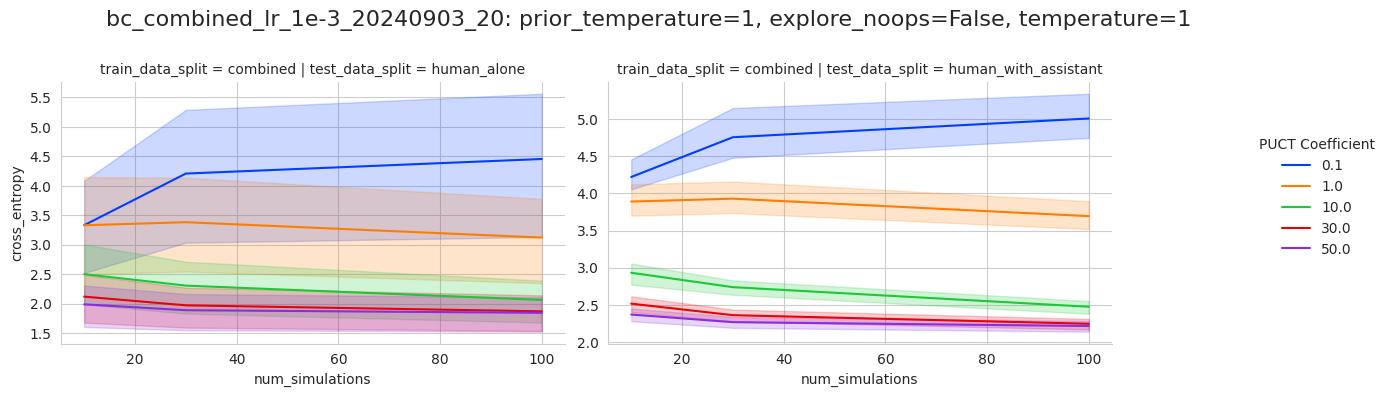

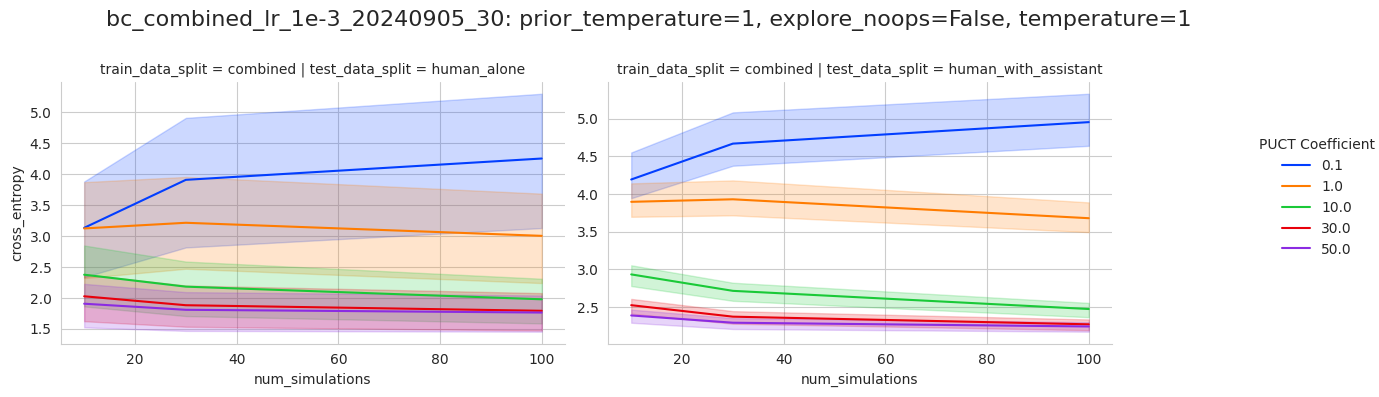

In [10]:
def plot_cross_entropy_by_combinations(df):
    # Get unique combinations of 'name', 'prior_temperature', 'explore_noops', and 'temperature'
    unique_combinations = df[
        ["human_model_name", "prior_temperature", "explore_noops", "temperature"]
    ].drop_duplicates()

    # Loop over each unique combination
    for _, combo in unique_combinations.iterrows():
        # Filter the dataframe for this unique combination
        filtered_df = df[
            (df["human_model_name"] == combo["human_model_name"])
            & (df["prior_temperature"] == combo["prior_temperature"])
            & (df["explore_noops"] == combo["explore_noops"])
            & (df["temperature"] == combo["temperature"])
        ]

        # Create the plot with subfigures based on train_data_split (rows) and test_data_split (columns)
        g = sns.relplot(
            data=filtered_df,
            x="num_simulations",
            y="cross_entropy",
            hue="puct_coefficient",
            kind="line",
            row="train_data_split",
            col="test_data_split",
            facet_kws={"sharey": False, "sharex": True},
            weights=filtered_df["episode_length"],  # Use episode_length as weights
            palette="bright",
            height=4,
            aspect=1.5,
        )

        # Adjust the layout to make room for the legend outside
        g.fig.subplots_adjust(top=0.8, right=0.85)

        # Place the legend outside the plot
        g._legend.set_bbox_to_anchor((1.05, 0.5))
        g._legend.set_title("PUCT Coefficient")

        # Set the main title of the plot
        title = f"{combo['human_model_name']}: prior_temperature={combo['prior_temperature']}, explore_noops={combo['explore_noops']}, temperature={combo['temperature']}"
        g.fig.suptitle(title, fontsize=16)

        # Show the plot
        plt.show()


with sns.axes_style("whitegrid"):
    plot_cross_entropy_by_combinations(pikl_human_modeling_metrics_df)

## Load goal eval results

In [15]:
experiment_utils = reload(experiment_utils)

alphazero_eval = dict(
    name="alphazero_6x64_240604_150",
    checkpoint_dir="/nas/ucb/ebronstein/minecraft-building-assistance-game/data/logs/MbagAlphaZero/self_play/11x10x10/craftassist/teleportation_False/inf_blocks_True/batch_32704/horizon_1500/truncate_episodes/trunc_no_progress_100/rollout_511/replay_20/train_1x8/max_seq_len_511/gamma_0.95/lr_0.001/model_6x64/sep_transformer/grad_clip_10/noop_reward_-0.2/361273/2024-06-04_02-10-37/1/checkpoint_000150",
    algorithm="alphazero",
    goal_eval_dir="/nas/ucb/ebronstein/minecraft-building-assistance-game/data/logs/MbagAlphaZero/self_play/11x10x10/craftassist/teleportation_False/inf_blocks_True/batch_32704/horizon_1500/truncate_episodes/trunc_no_progress_100/rollout_511/replay_20/train_1x8/max_seq_len_511/gamma_0.95/lr_0.001/model_6x64/sep_transformer/grad_clip_10/noop_reward_-0.2/361273/2024-06-04_02-10-37/1/checkpoint_000150/evaluate_test_1_sim_full_support_old_2024-06-26_21-14-04",
)
ppo_eval = dict(
    name="ppo_6x64_20240528_150",
    checkpoint_dir="/nas/ucb/cassidy/minecraft-building-assistance-game/data/logs/MbagPPO/self_play/11x10x10/craftassist/inf_blocks_True/horizon_1500_truncate_None/get_resources_0.0/lr_3e-4/3_sgd_iter/clip_0.2/reward_scale_1.0/vf_loss_0.01/gamma_0.95/6_layers/64_channels/entropy_0.03/kl_target_0.01/seed_0/2024-05-28_13-02-35/1/checkpoint_000150",
    algorithm="ppo",
)

bc_evals = [
    dict(
        name="bc_human_alone_rand_init_6x64_20240604_20",
        checkpoint_dir="/nas/ucb/ebronstein/minecraft-building-assistance-game/data/logs/BC/self_play/11x10x10/craftassist/teleportation_False/inf_blocks_True/split_human_alone/lr_0.001/seed_0/361299/2024-06-04_03-19-30/1/checkpoint_000020",
    ),
    dict(
        name="bc_human_with_assistant_rand_init_6x64_20240624_20",
        checkpoint_dir="/nas/ucb/ebronstein/minecraft-building-assistance-game/data/logs/BC/self_play/11x10x10/craftassist/teleportation_False/inf_blocks_True/split_human_with_assistant/mask_other_players_False/lr_0.001/seed_0/371064/2024-06-24_22-15-12/1/checkpoint_000020",
    ),
    dict(
        name="bc_combined_rand_init_6x64_20240624_20",
        checkpoint_dir="/nas/ucb/ebronstein/minecraft-building-assistance-game/data/logs/BC/self_play/11x10x10/craftassist/teleportation_False/inf_blocks_True/split_combined/mask_other_players_False/lr_0.001/seed_0/371070/2024-06-24_15-15-12/1/checkpoint_000020",
    ),
    dict(
        name="bc_human_alone_lr_1e-4_init_ppo_6x64_20240528_150_20240628_20",
        checkpoint_dir="/nas/ucb/cassidy/minecraft-building-assistance-game/data/logs/BC/self_play/11x10x10/craftassist/bc_human/lr_0.0001/infinite_blocks_true/human_alone/init_ppo_6x64_20240528_150/2024-06-28_17-10-55/1/checkpoint_000020",
    ),
    dict(
        name="bc_human_alone_lr_1e-3_init_ppo_6x64_20240528_150_20240628_20",
        checkpoint_dir="/nas/ucb/cassidy/minecraft-building-assistance-game/data/logs/BC/self_play/11x10x10/craftassist/bc_human/lr_0.001/infinite_blocks_true/human_alone/init_ppo_6x64_20240528_150/2024-06-28_17-11-00/1/checkpoint_000020",
    ),
    dict(
        name="bc_human_with_assistant_lr_1e-4_init_ppo_6x64_20240528_150_20240628_20",
        checkpoint_dir="/nas/ucb/cassidy/minecraft-building-assistance-game/data/logs/BC/self_play/11x10x10/craftassist/bc_human/lr_0.0001/infinite_blocks_true/human_with_assistant/init_ppo_6x64_20240528_150/2024-06-28_17-11-05/1/checkpoint_000020",
    ),
    dict(
        name="bc_human_with_assistant_lr_1e-3_init_ppo_6x64_20240528_150_20240628_20",
        checkpoint_dir="/nas/ucb/cassidy/minecraft-building-assistance-game/data/logs/BC/self_play/11x10x10/craftassist/bc_human/lr_0.001/infinite_blocks_true/human_with_assistant/init_ppo_6x64_20240528_150/2024-06-28_17-13-11/1/checkpoint_000020",
    ),
    dict(
        name="bc_combined_lr_1e-4_init_ppo_6x64_20240528_150_20240628_20",
        checkpoint_dir="/nas/ucb/cassidy/minecraft-building-assistance-game/data/logs/BC/self_play/11x10x10/craftassist/bc_human/lr_0.0001/infinite_blocks_true/combined/init_ppo_6x64_20240528_150/2024-06-28_17-13-18/1/checkpoint_000020",
    ),
    dict(
        name="bc_combined_lr_1e-3_init_ppo_6x64_20240528_150_20240628_20",
        checkpoint_dir="/nas/ucb/cassidy/minecraft-building-assistance-game/data/logs/BC/self_play/11x10x10/craftassist/bc_human/lr_0.001/infinite_blocks_true/combined/init_ppo_6x64_20240528_150/2024-06-28_17-13-21/1/checkpoint_000020",
    ),
]
for eval_dict in bc_evals:
    eval_dict["algorithm"] = "bc"

human_evals = [
    dict(
        name=f"human_{split}" if not split.startswith("human") else split,
        algorithm="human",
        split=split,
        metrics_path=f"/nas/ucb/cassidy/minecraft-building-assistance-game/data/human_data_cleaned/{split}/infinite_blocks_true/rllib_with_own_noops_flat_actions_flat_observations_place_wrong_reward_-1_repaired_player_0_metrics.json",
    )
    for split in ["human_alone", "human_with_assistant"]
]

eval_dicts = human_evals  # [alphazero_eval, ppo_eval, *bc_evals, *human_evals]

dfs = []

# Load episode metrics for all of the evals.
for eval_dict in eval_dicts:
    checkpoint_dir = (
        pathlib.Path(eval_dict["checkpoint_dir"])
        if "checkpoint_dir" in eval_dict
        else None
    )
    algorithm = eval_dict["algorithm"]
    if algorithm == "human":
        goal_eval_metrics_path = eval_dict["metrics_path"]
    else:
        if checkpoint_dir is None or not checkpoint_dir.exists():
            raise FileNotFoundError(f"Train dir {checkpoint_dir} does not exist.")
        goal_eval_dir = eval_dict.get("goal_eval_dir")
        if goal_eval_dir is not None:
            goal_eval_dir = pathlib.Path(goal_eval_dir)
            goal_eval_metrics_path = goal_eval_dir / "metrics.json"
        else:
            goal_eval_metrics_paths = list(
                checkpoint_dir.glob("evaluate_test_*/metrics.json")
            )
            if len(goal_eval_metrics_paths) > 1:
                print(
                    f"Warning: Found {len(goal_eval_metrics_paths)} goal eval metrics in {checkpoint_dir}, using the most recent one."
                )
            # Use the most recent goal eval dir.
            goal_eval_metrics_path = max(
                goal_eval_metrics_paths, key=lambda d: os.path.getmtime(str(d))
            )

    episode_metrics_df = experiment_utils.load_episode_metrics(goal_eval_metrics_path)
    for i, key in enumerate(["name", "checkpoint_dir", "algorithm"]):
        episode_metrics_df.insert(i, key, eval_dict.get(key))

    if algorithm in ["alphazero", "ppo"]:
        train_split = "none"
    elif algorithm == "human":
        train_split = eval_dict["split"]
    elif algorithm == "bc":
        with open(checkpoint_dir.parent / "config.json", "r") as f:
            config = json.load(f)
        train_split = config["data_split"]
    else:
        # TODO
        raise NotImplementedError()
    episode_metrics_df.insert(2, "train_data_split", train_split)

    dfs.append(episode_metrics_df)

df = pd.concat(dfs, ignore_index=True)

# Check that the human metrics have the same train_data_split as the name.
# This should be true by construction.
human_df = df[df["algorithm"] == "human"]
assert (human_df["name"] == human_df["train_data_split"]).all()

# Add piKL metrics
df = pd.concat([df, pikl_goal_metrics_df], ignore_index=True)

## piKL

### Line plots

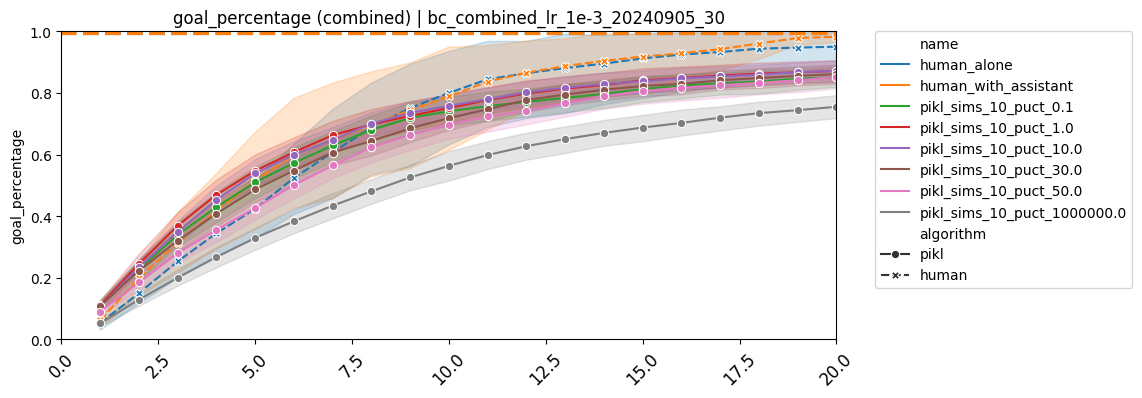

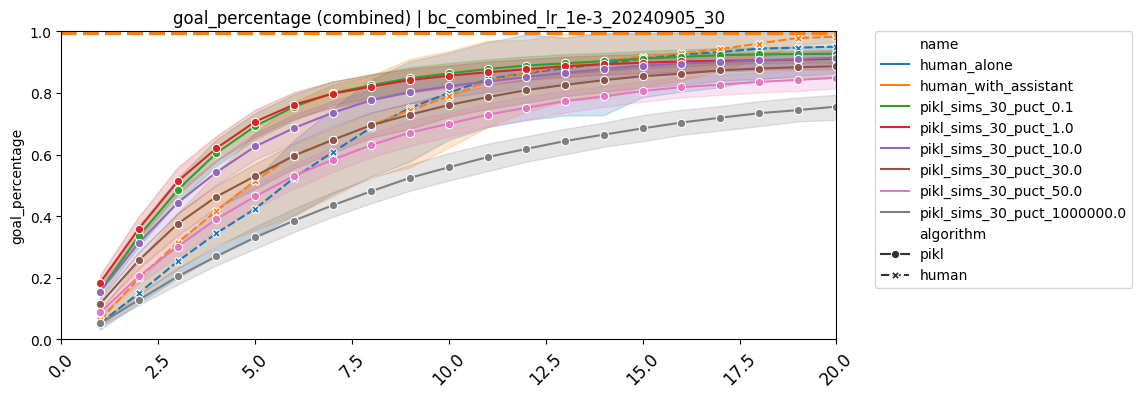

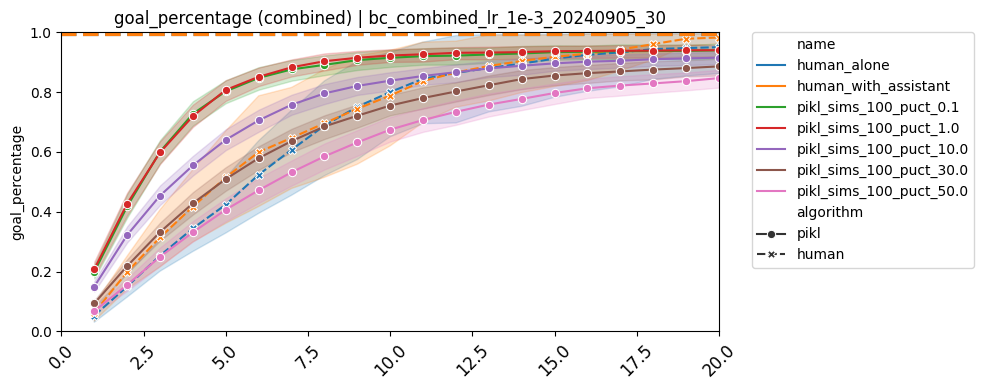

In [18]:
# Flag to make one big figure or multiple figures.
save_fig = False
plot_subdir = "sim_100"

if save_fig:
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    plot_dir = pathlib.Path("plots/per_minute_metrics") / plot_subdir / timestamp
    plot_dir.mkdir(parents=True)

# Specific metrics and times in a custom order.
# The times indicate at which time interval the metric was computed. NaN indicates
# that the metric is for the whole episode.
metrics = [
    "goal_percentage",
    # "num_move_percentage",
    # "num_place_block_percentage",
    # "num_break_block_percentage",
    # "num_noop_percentage",
    # "num_place_block",
    # # "num_correct_place_block",
    # "place_block_accuracy",
    # "num_break_block",
    # # "num_correct_break_block",
    # "break_block_accuracy",
    # "num_move",
    # "num_noop",
]
n_metrics = len(metrics)

names = [
    ### Human baselines
    "human_alone",
    "human_with_assistant",
    ### piKL
    "pikl_sims_10_puct_0.1",
    "pikl_sims_30_puct_0.1",
    "pikl_sims_100_puct_0.1",
    "pikl_sims_10_puct_1.0",
    "pikl_sims_30_puct_1.0",
    "pikl_sims_100_puct_1.0",
    "pikl_sims_10_puct_10.0",
    "pikl_sims_30_puct_10.0",
    "pikl_sims_100_puct_10.0",
    "pikl_sims_10_puct_30.0",
    "pikl_sims_30_puct_30.0",
    "pikl_sims_100_puct_30.0",
    "pikl_sims_10_puct_50.0",
    "pikl_sims_30_puct_50.0",
    "pikl_sims_100_puct_50.0",
    "pikl_sims_10_puct_1000000.0",
    "pikl_sims_30_puct_1000000.0",
    ### DiL-piKL
    # "pikl_sims_100_puct_[1, 10, 100]",
    # "pikl_sims_100_puct_[1, 100]",
    # "pikl_sims_100_puct_[0.1, 1, 10, 100]",
    # "pikl_sims_100_puct_[0.1, 10, 10, 100]",
    # "pikl_sims_100_puct_[0.1, 100]",
    # "pikl_sims_100_puct_[1, 1, 10, 100]",
    ### piKL puct_coefficient_schedule
    # "pikl_sims_100_puct_[(0, 30.0), (1000, 0.1)]",
    # "pikl_sims_100_puct_[(0, 50.0), (1000, 0.1)]",
    # "pikl_sims_100_puct_[(0, 100.0), (1000, 0.1)]",
]

# num_simulations filter for piKL
num_sims_list = sorted(df.query("algorithm == 'pikl'")["num_simulations"].unique())

# Filter for piKL and human baselines.
pikl_human_df = df.query("algorithm in ['pikl', 'human']")
# Filter by name.
if names:
    pikl_human_df = pikl_human_df[pikl_human_df["name"].isin(names)]

y_lims = {}
y_lims.update(
    {m: (0, 1) for m in metrics if "percentage" in m or m.endswith("accuracy")}
)
y_lims.update({m: (0, None) for m in metrics if m.startswith("num")})

mpl_rc = {
    # "font.size": 20,
    # "axes.titlesize": 20,
    # "axes.labelsize": 50,
    # "xtick.labelsize": "large",
    # "ytick.labelsize": "large",
}

if names:
    name_order = [name for name in names if name in pikl_human_df["name"].unique()]
else:
    name_order = sorted(pikl_human_df["name"].unique())
n_names = len(name_order)

pikl_human_model_names = sorted(
    list(
        pikl_human_df[pikl_human_df["algorithm"] == "pikl"]["human_model_name"].unique()
    )
)
n_pikl_human_model_names = len(pikl_human_model_names)

# Only consider train splits for piKL.
train_splits = list(
    pikl_human_df[pikl_human_df["algorithm"] == "pikl"]["train_data_split"].unique()
)
n_train_splits = len(train_splits)

with mpl.rc_context(mpl_rc):
    for i, metric in enumerate(metrics):
        pikl_human_metric_df = pikl_human_df[pikl_human_df["metric"] == metric]
        for num_sims in num_sims_list:
            pikl_human_metric_num_sims_df = pikl_human_metric_df[
                (pikl_human_metric_df["num_simulations"] == num_sims)
                | (pikl_human_metric_df["algorithm"] == "human")
            ]

            fig, axes = plt.subplots(
                nrows=n_train_splits,
                ncols=n_pikl_human_model_names,
                figsize=(n_pikl_human_model_names * 10, n_train_splits * 4),
            )
            if n_train_splits == 1 or n_pikl_human_model_names == 1:
                axes = np.array([axes]).reshape(
                    n_train_splits, n_pikl_human_model_names
                )

            y_lim = y_lims.get(metric)

            for i in range(n_train_splits):
                for j in range(n_pikl_human_model_names):
                    ax = axes[i, j]
                    train_split = train_splits[i]
                    pikl_human_model_name = pikl_human_model_names[j]

                    metric_split_data = pikl_human_metric_num_sims_df[
                        (
                            (
                                pikl_human_metric_num_sims_df["train_data_split"]
                                == train_split
                            )
                            & (
                                pikl_human_metric_num_sims_df["human_model_name"]
                                == pikl_human_model_name
                            )
                        )
                        | (pikl_human_metric_num_sims_df["algorithm"] == "human")
                    ]

                    name_order_for_plot = [
                        name
                        for name in name_order
                        if name in metric_split_data["name"].unique()
                    ]
                    palette = sns.color_palette(n_colors=len(name_order_for_plot))

                    sns.lineplot(
                        data=metric_split_data,
                        x="time",
                        y="value",
                        hue="name",
                        style="algorithm",
                        style_order=["pikl", "human"],
                        markers=True,
                        hue_order=name_order_for_plot,
                        palette=palette,
                        ax=ax,
                    )

                    # Add horizontal lines for human baselines.
                    for name, group_df in pikl_human_metric_num_sims_df.query(
                        "algorithm == 'human'"
                    ).groupby("name"):
                        if len(group_df) == 0:
                            continue

                        assert group_df["train_data_split"].nunique() == 1
                        human_metric_median = group_df["value"].median()
                        ax.axhline(
                            y=human_metric_median,
                            color=palette[name_order.index(name)],
                            linestyle="--",
                            linewidth=3,
                        )

                    ax.set_xlim(0, 20)
                    if y_lim is not None:
                        ax.set_ylim(*y_lims[metric])

                    ax.set_title(f"{metric} ({train_split}) | {pikl_human_model_name}")
                    ax.set_ylabel(metric)
                    ax.set_xlabel("")
                    ax.set_xticks(
                        ax.get_xticks(),
                        labels=ax.get_xticklabels(),
                        rotation=45,
                        size="large",
                    )
                    # Move the legend outside the plot
                    ax.legend(
                        bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0
                    )

        plt.tight_layout()
        if save_fig:
            plt.savefig(plot_dir / f"pikl_human_model_{metric}.png")
        plt.show()

### Violin plots

In [ ]:
# Flag to make one big figure or multiple figures.
one_fig = False
save_fig = True

if save_fig:
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    plot_dir = pathlib.Path("plots") / timestamp
    plot_dir.mkdir(parents=True)

# Specific metrics and times in a custom order.
# The times indicate at which time interval the metric was computed. NaN indicates
# that the metric is for the whole episode.
metrics = [
    *[("goal_percentage", t) for t in [1, 2, 3, 4, 5, 8, 10, 15, 20]],
    ("num_move_percentage", float("nan")),
    ("num_place_block_percentage", float("nan")),
    ("num_break_block_percentage", float("nan")),
    ("num_noop_percentage", float("nan")),
    ("num_place_block", float("nan")),
    ("num_correct_place_block", float("nan")),
    ("place_block_accuracy", float("nan")),
    ("num_break_block", float("nan")),
    ("num_correct_break_block", float("nan")),
    ("break_block_accuracy", float("nan")),
    ("num_move", float("nan")),
    ("num_noop", float("nan")),
    # "cross_entropy_mean",
    # "cross_entropy",
]
n_metrics = len(metrics)

names = [
    "human_alone",
    "human_with_assistant",
    "pikl_sims_30_puct_1",
    "pikl_sims_100_puct_1",
    "pikl_sims_30_puct_10",
    "pikl_sims_100_puct_10",
    "pikl_sims_30_puct_30",
    "pikl_sims_100_puct_30",
    "pikl_sims_30_puct_[1, 100]",
    "pikl_sims_100_puct_[1, 100]",
    "pikl_sims_30_puct_[1, 10, 100]",
    "pikl_sims_100_puct_[1, 10, 100]",
]

# Filter for piKL and human baselines.
data = df.query("algorithm in ['pikl', 'human']")
# Filter by name.
data = data[data["name"].isin(names)]

# Get unique train_split values for human models (including None if it exists)
human_data = data[data["algorithm"] == "human"]
human_model_data = data[data["algorithm"] != "human"]

y_lims = {}
# y_lims.update({m: (0, 1) for m, _ in metrics if "percentage" in m or m.endswith("accuracy")})
y_lims.update({m: (0, None) for m, _ in metrics if m.startswith("num")})

mpl_rc = {
    "font.size": 20,
    "axes.titlesize": 50,
    "axes.labelsize": 50,
    "xtick.labelsize": "large",
    "ytick.labelsize": "large",
}

n_models = data["name"].nunique()
train_splits = list(data["train_data_split"].unique())
n_train_splits = len(train_splits)
order = [
    "human_alone",
    "human_with_assistant",
    "pikl_sims_10_puct_10",
    "pikl_sims_30_puct_10",
    "pikl_sims_100_puct_10",
    "pikl_sims_10_puct_30",
    "pikl_sims_30_puct_30",
    "pikl_sims_100_puct_30",
    "pikl_sims_10_puct_50",
    "pikl_sims_30_puct_50",
    "pikl_sims_100_puct_50",
]

with mpl.rc_context(mpl_rc):
    # Generate a color palette
    palette = sns.color_palette(n_colors=n_train_splits)

    if one_fig:
        fig, axes = plt.subplots(
            nrows=n_metrics, ncols=1, figsize=(n_models * 6, n_metrics * 20)
        )

    for i, (metric, time) in enumerate(metrics):
        if one_fig:
            ax = axes[i]
        else:
            fig, ax = plt.subplots(figsize=(n_models * 6, 20))

        y_lim = y_lims.get(metric)
        metric_data = data[(data["metric"] == metric)]
        time_mask = pd.isna(data["time"]) if pd.isna(time) else (data["time"] == time)
        metric_data = metric_data[time_mask]

        if metric == "cross_entropy_mean":
            # Show a bar plot for mean cross entropy.
            sns.barplot(
                data=metric_data,
                x="name",
                y="value",
                hue="train_data_split",
                hue_order=train_splits,
                palette=palette,
                ax=ax,
            )
        elif metric == "num_action_or_noop":
            # Show a box and whisker plot.
            sns.boxplot(
                data=metric_data,
                x="name",
                y="value",
                hue="train_data_split",
                hue_order=train_splits,
                palette=palette,
                ax=ax,
            )
        else:
            # Show a violin plot for other metrics.
            cut = 2 if y_lim is None else 0
            sns.violinplot(
                data=metric_data,
                x="name",
                y="value",
                hue="train_data_split",
                hue_order=train_splits,
                split=True,
                gap=0.1,
                cut=cut,
                palette=palette,
                ax=ax,
            )

        # Add horizontal lines for human baselines.
        for key, group_df in metric_data.query("algorithm == 'human'").groupby(
            ["name", "train_data_split"]
        ):
            if len(group_df) == 0:
                continue

            assert group_df["train_data_split"].nunique() == 1
            human_train_split = group_df["train_data_split"].unique()[0]
            human_metric_median = group_df["value"].median()
            ax.axhline(
                y=human_metric_median,
                color=palette[train_splits.index(human_train_split)],
                linestyle="--",
                linewidth=3,
            )

        if y_lim is not None:
            ax.set_ylim(*y_lims[metric])

        title = metric if pd.isna(time) else f"{metric} ({time} min)"
        ax.set_title(title)
        ax.set_ylabel(title)
        ax.set_xlabel("")
        ax.set_xticks(
            ax.get_xticks(), labels=ax.get_xticklabels(), rotation=45, size="large"
        )

        if not one_fig:
            plt.tight_layout()
            if save_fig:
                metric_fname = metric if pd.isna(time) else f"{metric}_{time}_min"
                plt.savefig(plot_dir / f"pikl_human_model_{metric_fname}.png")
            plt.show()

    if one_fig:
        plt.tight_layout()
        if save_fig:
            plt.savefig(plot_dir / "pikl_human_model_all_metrics.png")
        plt.show()

## Violinplots

### Main human models

In [ ]:
# Specific metrics in a custom order.
metrics = [
    "goal_percentage_5_min",
    "goal_percentage_10_min",
    "goal_percentage_15_min",
    "goal_percentage_20_min",
    "num_place_block",
    "num_correct_place_block",
    "place_block_accuracy",
    "num_break_block",
    "num_correct_break_block",
    "break_block_accuracy",
    "num_move",
    "num_noop",
]
n_metrics = len(metrics)

y_lims = {m: (0, 1) for m in metrics if m.startswith("goal_percentage")}

data = df[df["algorithm"] != "pikl"]

# Get unique train_split values for human models (including None if it exists)
human_data = data[data["algorithm"] == "human"]
human_model_data = data[data["algorithm"] != "human"]

mpl_rc = {
    "font.size": 20,
    "axes.titlesize": 50,
    "axes.labelsize": 50,
    "xtick.labelsize": "large",
    "ytick.labelsize": "large",
}

with mpl.rc_context(mpl_rc):
    # Generate a color palette
    n_models = data["name"].nunique()
    palette = sns.color_palette(n_colors=n_models)

    fig, axes = plt.subplots(
        nrows=n_metrics, ncols=1, figsize=(n_models * 6, n_metrics * 20)
    )
    # fig.subplots_adjust(top=0.8)
    # fig.suptitle(name, y=1)

    for i, (ax, metric) in enumerate(zip(axes, metrics)):
        # for i, metric in enumerate(metrics):
        #     fig, ax = plt.subplots(figsize=(n_models * 6, 6))

        y_lim = y_lims.get(metric)
        cut = 2 if y_lim is None else 0
        sns.violinplot(
            data=data,
            x="name",
            y=metric,
            hue="name",
            cut=cut,
            palette=palette,
            legend=False,
            ax=ax,
        )

        if y_lim is not None:
            ax.set_ylim(*y_lims[metric])
        ax.set_title(metric)
        ax.set_ylabel(metric)
        ax.set_xlabel("")
        ax.set_xticks(
            ax.get_xticks(), labels=ax.get_xticklabels(), rotation=45, size="large"
        )

    plt.tight_layout()
    plt.show()

## DiL-piKL human modeling eval

In [ ]:
# DiL-piKL human modeling eval

import scipy

experiment_utils = reload(experiment_utils)

train_split = "human_alone"
test_split = "human_alone"

all_dil_pikl_experiment_configs = {}
for puct_coefficient_mixture in [
    [1, 100],
    [10, 100],
    [1, 10, 100],
]:
    for num_simulations in [
        10,
        30,
        # 100,
    ]:
        puct_coefficient_str = ",".join(map(str, puct_coefficient_mixture))
        name = f"puct={puct_coefficient_str} sims={num_simulations}"
        experiment_configs = [
            dict(puct_coefficient=puct_coefficient, num_simulations=num_simulations)
            for puct_coefficient in puct_coefficient_mixture
        ]
        for config in experiment_configs:
            config.update(
                {
                    "SPLIT": train_split,
                    "TEST_SPLIT": test_split,
                    "VALIDATION_PARTICIPANT_IDS": None,
                    "algorithm": "pikl",
                }
            )

        all_dil_pikl_experiment_configs[name] = experiment_configs


compute_cross_entropy = False
cross_entropy_df = []

for name, dil_pikl_experiment_configs in all_dil_pikl_experiment_configs.items():
    dil_pikl_eval_human_modeling_metrics_list = []
    test_data_splits = set()

    for config in dil_pikl_experiment_configs:
        (
            human_modeling_env_vars_list,
            human_modeling_metrics_list,
            _,
            _,
        ) = experiment_utils.get_human_eval_env_vars_and_metrics_for_experiment(
            config,
            AGENT,
            goal_eval=False,
            require_training_completed=True,
            repeat_eval_if_exists=False,
        )
        dil_pikl_eval_human_modeling_metrics_list.append(human_modeling_metrics_list)
        test_data_splits.add(config["TEST_SPLIT"])

    assert (
        len(test_data_splits) == 1
    ), f"Only one test data split should be used per DiL-piKL combination, got {len(test_data_splits)}."
    test_data_split = test_data_splits.pop()

    logprobs = experiment_utils.get_human_modeling_logprobs_for_experiments(
        dil_pikl_eval_human_modeling_metrics_list
    )

    pad_logprobs = experiment_utils.pad_human_modeling_logprobs(logprobs)
    assert all(
        (np.isfinite(pad_logprobs[i]) == np.isfinite(pad_logprobs[0])).all()
        for i in range(1, len(pad_logprobs))
    ), "Not all experiments have the same number of episodes and steps per participant."

    # Compute the mixture logprobs.
    # [n_participants, n_episodes, n_steps]
    mixture_logprobs = scipy.special.logsumexp(pad_logprobs, axis=0) - np.log(
        pad_logprobs.shape[0]
    )

    # Compute cross entropies for each time interval.
    secs_per_step = 0.8
    steps_per_min = 1 / secs_per_step * 60
    minute_interval = 5  # Interval for computing cross entropy.
    steps_per_interval = int(steps_per_min * minute_interval)
    n_intervals = np.ceil(mixture_logprobs.shape[-1] / steps_per_interval).astype(int)

    interval_times = [
        (i * steps_per_interval, (i + 1) * steps_per_interval)
        for i in range(n_intervals)
    ]

    intervals_results = []
    for start, end in interval_times:
        interval_logprobs = mixture_logprobs[..., start:end]
        start_time = start / steps_per_min
        if start_time == int(start_time):
            start_time = int(start_time)
        end_time = end / steps_per_min
        if end_time == int(end_time):
            end_time = int(end_time)

        if compute_cross_entropy:
            interval_cross_entropy = experiment_utils.compute_mixture_cross_entropy(
                interval_logprobs
            )
            result = {
                "start_time": start_time,
                "end_time": end_time,
                "cross_entropy": interval_cross_entropy,
            }
            intervals_results.append(result)
        else:
            valid_interval_logprobs = interval_logprobs[
                experiment_utils.valid_logprobs_mask(interval_logprobs)
            ]
            for logprob in valid_interval_logprobs.flatten():
                result = {
                    "start_time": start_time,
                    "end_time": end_time,
                    "neg_logprob": -logprob,
                }
                intervals_results.append(result)

    df = pd.DataFrame(intervals_results)
    df.insert(0, "name", name)
    df.insert(1, "test_data_split", test_data_split)
    cross_entropy_df.append(df)

cross_entropy_df = pd.concat(cross_entropy_df)

In [ ]:
# Negative logprob vs. time line plot with CIs

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(
    data=cross_entropy_df,
    x="start_time",
    y="neg_logprob",
    hue="name",
    style="test_data_split",
    marker="o",
    ax=ax,
)
ax.set_title(f"DiL-piKL Cross Entropy ({minute_interval} min. interval)")
ax.set_xlabel("Time (min)")
ax.set_ylabel("Negative Log Probability")
plt.tight_layout()
plt.show()

In [ ]:
# Negative logprob vs. time violin plot

n_experiments = cross_entropy_df["name"].nunique()
fig, ax = plt.subplots(figsize=(5 * n_experiments, 10))
sns.violinplot(
    data=cross_entropy_df,
    x="start_time",
    y="neg_logprob",
    hue="name",
    split=False,
    gap=0.1,
    ax=ax,
)
ax.set_ylim((0, 6))
ax.set_title(f"DiL-piKL Cross Entropy ({minute_interval} min. interval)")
ax.set_xlabel("Time (min)")
ax.set_ylabel("Negative Log Probability")
plt.tight_layout()
plt.show()

## Boxplots & histograms per model & metric

In [ ]:
# List of metrics (excluding 'name', 'checkpoint_dir', 'algorithm', 'train_split')
# metrics = sorted(
#     df.columns.difference(["name", "checkpoint_dir", "algorithm", "train_split"])
# )
# Specific metrics in a custom order.
metrics = [
    "goal_percentage_5_min",
    "goal_percentage_10_min",
    "goal_percentage_15_min",
    "goal_percentage_20_min",
    "num_place_block",
    "num_correct_place_block",
    "place_block_accuracy",
    "num_break_block",
    "num_correct_break_block",
    "break_block_accuracy",
    "num_move",
    "num_noop",
]
n_metrics = len(metrics)

# Get unique train_split values for human models (including None if it exists)
human_data = df[df["algorithm"] == "human"]
human_model_data = df[df["algorithm"] != "human"]

# Generate a color palette
n_colors = 1 + human_data["name"].nunique()
palette = sns.color_palette(n_colors=n_colors)

for name, group_df in human_model_data.groupby("name"):
    group_df = group_df.copy()
    # Replace the human model name with the algorithm so the legend is more readable.
    group_df["name"] = group_df["algorithm"]

    fig, axes = plt.subplots(nrows=n_metrics, ncols=2, figsize=(10, n_metrics * 5))
    fig.subplots_adjust(top=0.8)
    fig.suptitle(name, y=1)

    data = pd.concat([group_df, human_data], ignore_index=True)
    for i, (ax1, ax2, metric) in enumerate(zip(axes[:, 0], axes[:, 1], metrics)):
        ax_title = metric

        sns.violinplot(
            data=data,
            x="name",
            y=metric,
            hue="name",
            palette=palette,
            legend=i == 0,
            ax=ax1,
        )
        ax1.set_title(ax_title)
        ax1.set_ylabel(metric)
        ax1.set_xlabel("")
        ax1.set_xticks([])
        if i == 0:
            # Move the legend below the subplot.
            sns.move_legend(ax1, "upper center", bbox_to_anchor=(0.5, -0.1))

        # Set common_norm=False to normalize the human models and real human
        # data separately.
        sns.histplot(
            data=data,
            x=metric,
            hue="name",
            stat="probability",
            common_norm=False,
            element="step",
            palette=palette,
            legend=i == 0,
            ax=ax2,
        )
        ax2.set_title(ax_title)
        ax2.set_ylabel(metric)
        ax2.set_xlabel("")
        if i == 0:
            # Move the legend below the subplot.
            sns.move_legend(ax2, "upper center", bbox_to_anchor=(0.5, -0.1))

    plt.tight_layout()
    plt.show()

# Cassidy's human model eval

In [ ]:
policies_df = experiment_utils.load_human_policies_df()

For both they expect policies_df to be from the spreadsheet

And if you set jobs = True they print out commands to run

If you set jobs = False they print out the results that can be copied into the spreadsheet

If you want to use them you’ll have to change some things since I’m assuming it’s running from my workstation which has the nas mounted at /media/nas-ucb

In [ ]:
# Human model evaluation (cross entropy)

jobs = False
num_simulations = 1

for human_model_row in list(policies_df.itertuples()):
    local_checkpoint_dir: str = human_model_row.human_model_checkpoint.replace(
        "/nas/ucb", "/media/nas-ucb"
    )

    checkpoints: List[Tuple[Optional[float]]] = []
    if human_model_row.human_data_split != "none":
        # Cross validation
        checkpoint_parts = local_checkpoint_dir.split(os.path.sep)
        local_cross_validation_checkpoint_dirs = glob.glob(
            os.path.sep.join(
                checkpoint_parts[:-3] + ["validation_*", "*"] + checkpoint_parts[-2:]
            )
        )
        # assert len(local_cross_validation_checkpoint_dirs) == 5
        for (
            local_cross_validation_checkpoint_dir
        ) in local_cross_validation_checkpoint_dirs:
            validation_participant_id = int(
                local_cross_validation_checkpoint_dir.split(os.path.sep)[-4][
                    len("validation_") :
                ]
            )
            checkpoints.append(
                (validation_participant_id, local_cross_validation_checkpoint_dir),
            )
    else:
        checkpoints.append(
            (None, local_checkpoint_dir),
        )

    episode_results = []

    for validation_participant_id, local_checkpoint_dir in checkpoints:
        for data_split in ["human_alone"]:  # , "human_with_assistant"]:
            inf_blocks = str(human_model_row.inf_blocks).lower()
            run = human_model_type_to_run[human_model_row.human_model_type]
            experiment_tag = data_split

            extra_config_updates = {}
            if run == "MbagAlphaZero":
                extra_config_updates = {
                    "mcts_config": {
                        "num_simulations": num_simulations,
                    }
                }
                experiment_tag += f"_{num_simulations}_sim"

            evaluate_run_fnames = glob.glob(
                os.path.join(
                    local_checkpoint_dir,
                    f"evaluate_human_modeling_{experiment_tag}_*",
                    "*",
                    "run.json",
                )
            )
            evaluate_run_exists = False
            for train_run_fname in evaluate_run_fnames:
                with open(train_run_fname, "r") as run_fname:
                    try:
                        run_info = json.load(run_fname)
                    except json.decoder.JSONDecodeError:
                        continue
                if run_info["status"] in ["RUNNING", "COMPLETED"]:
                    if run_info["status"] == "RUNNING":
                        # Only set run_exists = True if the file at run_fname was modified in the past hour
                        if time.time() - os.path.getmtime(train_run_fname) < 60 * 60:
                            evaluate_run_exists = True
                    else:
                        evaluate_run_exists = True
                        episode_results.extend(run_info["result"]["episode_results"])
                if evaluate_run_exists:
                    break

            if evaluate_run_exists:
                continue
            if not jobs:
                continue

            checkpoint_dir = local_checkpoint_dir.replace("/media/nas-ucb", "/nas/ucb")
            participant_ids = (
                None
                if validation_participant_id is None
                else [validation_participant_id]
            )

            print(
                "python -m mbag.scripts.evaluate_human_modeling with "
                f"run={run} checkpoint={checkpoint_dir} "
                f"policy_id=human experiment_tag={experiment_tag} "
                f"participant_ids={participant_ids} "
                f'extra_config_updates="{extra_config_updates}" '
                f"human_data_dir=data/human_data_cleaned/{data_split}/infinite_blocks_{inf_blocks}/rllib_with_noops_flat_actions_flat_observations_player_0"
            )

    if not jobs:
        if len(episode_results) == 9:
            total_accuracy = 0
            total_cross_entropy = 0
            total_count = 0
            for episode in episode_results:
                total_accuracy += episode["accuracy"] * episode["length"]
                total_cross_entropy += episode["cross_entropy"] * episode["length"]
                total_count += episode["length"]
            accuracy = total_accuracy / total_count
            cross_entropy = total_cross_entropy / total_count
            print(cross_entropy, accuracy, sep="\t")
        else:
            print()

In [ ]:
# Human model evaluation (goal percentage)

jobs = False
num_simulations = 1
subset = "test"

for human_model_row in list(policies_df.itertuples()):
    local_checkpoint_dir: str = human_model_row.human_model_checkpoint.replace(
        "/nas/ucb", "/media/nas-ucb"
    )

    inf_blocks = str(human_model_row.inf_blocks).lower()
    run = experiment_utils.ALGORITHM_TO_NAME[human_model_row.human_model_type]
    experiment_tag = subset

    algorithm_config_updates = {}
    if run == "MbagAlphaZero":
        algorithm_config_updates = {
            "mcts_config": {
                "num_simulations": num_simulations,
            }
        }
        experiment_tag += f"_{num_simulations}_sim"

    env_config_updates = {
        "horizon": 1500,
        "truncate_on_no_progress_timesteps": None,
        "goal_generator_config": {
            "goal_generator_config": {
                "subset": subset,
            }
        },
    }

    evaluate_dirs = glob.glob(
        os.path.join(
            local_checkpoint_dir,
            f"evaluate_{experiment_tag}_*",
        )
    )
    evaluate_run_exists = False
    metrics_fname = None
    for evaluate_dir in evaluate_dirs:
        if os.path.exists(os.path.join(evaluate_dir, "metrics.json")):
            evaluate_run_exists = True
            metrics_fname = os.path.join(evaluate_dir, "metrics.json")
        elif time.time() - os.path.getmtime(evaluate_dir) < 60 * 60:
            evaluate_run_exists = True

    if jobs:
        if evaluate_run_exists:
            continue
        checkpoint_dir = local_checkpoint_dir.replace("/media/nas-ucb", "/nas/ucb")
        participant_ids = (
            None if validation_participant_id is None else [validation_participant_id]
        )

        num_episodes = 1000

        print(
            # "tss mbag -G 1 "
            "python -m mbag.scripts.evaluate with "
            f"runs='[\"{run}\"]' checkpoints='[\"{human_model_row.human_model_checkpoint}\"]' "
            f"policy_ids='[\"human\"]' experiment_tag={experiment_tag} "
            f"num_episodes={num_episodes} "
            f'algorithm_config_updates="{algorithm_config_updates}" '
            f'env_config_updates="{env_config_updates}" '
            f"num_workers=10"
        )
    else:
        if metrics_fname is not None:
            with open(metrics_fname, "r") as metrics_file:
                metrics = json.load(metrics_file)
            print(
                *[
                    metrics["mean_metrics"].get(f"goal_percentage_{num_min}_min", "")
                    for num_min in [5, 10, 15, 20]
                ],
                sep="\t",
            )
        else:
            print()

# Tensorboard

## Running/pending jobs

In [ ]:
experiments_df = experiment_utils.get_experiments_df(AGENT)
status_list = ["running", "pending"]
print(f"slurm_job_ids for {status_list} jobs:")
print(
    experiment_utils.get_slurm_job_ids_regex(
        experiments_df[experiments_df["status"].isin(status_list)]
    )
)

## Update spreadsheet job status

In [ ]:
experiments_df = experiment_utils.get_experiments_df(AGENT, add_gid=True)
experiments_id_status = experiments_df[["gid", "slurm_job_id", "status"]]
experiments_id_status = experiments_id_status.dropna(subset="status")
job_status_map = {
    "PENDING": "pending",
    "RUNNING": "running",
    "COMPLETED": "done",
    "FAILED": "failed",
    "CANCELLED": "canceled",
    "TIMEOUT": "timeout",
    "OUT_OF_MEMORY": "oom",
}
experiments_id_status["Current status"] = experiments_id_status["slurm_job_id"].apply(
    experiment_utils.check_slurm_job_status
)
experiments_id_status["Current status"] = experiments_id_status["Current status"].apply(
    lambda x: job_status_map.get(x, x)
)


# Show the experiments that have an outdated status.
outdated_status_mask = experiments_id_status.apply(
    experiment_utils.is_status_outdated, axis=1, fail_is_done=True
)
outdated_status_experiments = experiments_id_status[outdated_status_mask]
outdated_status_experiments.reindex(
    columns=["gid", "slurm_job_id", "status", "Current status"]
)

# Search for experiments

In [ ]:
experiments_df = experiment_utils.get_experiments_df(AGENT, add_gid=True)

In [ ]:
# Slurm job ID
job_ids = [327444, 327445]
experiments_subset_df = experiments_df.query("slurm_job_id in @job_ids")

# Custom
# experiments_subset_df = experiments_df.query("not INF_BLOCKS")

experiments_subset_df[
    [
        "slurm_job_id",
        "status",
        "INF_BLOCKS",
        "NUM_LAYERS",
        "HIDDEN_SIZE",
        "LR",
        "GAMMA",
        "HORIZON",
        "MAX_SEQ_LEN",
        "ROLLOUT_FRAGMENT_LENGTH",
        "SGD_MINIBATCH_SIZE",
    ]
]

In [ ]:
print(experiment_utils.get_slurm_job_ids_regex(experiments_subset_df))